# Carbon Footprint Eval

In [25]:
import pandas as pd
import gzip
import json
from tqdm import tqdm
from statistics import mean

RETRIEVAL_PARADIGMS = {
    'multi-qa-distilbert-cos-v1': 'Bi-Encoder',
    'DPH': 'Lexical',
    'multi-qa-minilm-l6-cos-v1': 'Bi-Encoder',
    'IFB2': 'Lexical',
    'InB2': 'Lexical',
    'msmarco-minilm-l12-cos-v5': 'Bi-Encoder',
    'PL2': 'Lexical',
    'BM25': 'Lexical',
    'hltcoe-plaidx-large-eng-tdist-mt5xxl-engeng': 'Late Interaction',
    'DirichletLM': 'Lexical',
    'colbert-ir-colbertv2.0': 'Late Interaction',
    'multi-qa-mpnet-base-cos-v1': 'Bi-Encoder',
    'sentence-transformers-msmarco-roberta-base-ance-firstp': 'Bi-Encoder',
    'TF_IDF': 'Lexical',
    'DFIZ': 'Lexical',
    'msmarco-minilm-l6-cos-v5': 'Bi-Encoder',
    'DLH': 'Lexical',
    'msmarco-distilbert-base-tas-b': 'Bi-Encoder',
    'colbert-ir-colbertv1.9': 'Late Interaction',
    'Hiemstra_LM': 'Lexical',
    'msmarco-distilbert-base-v3': 'Bi-Encoder',
}

def dataset_id_to_corpus_sizes():
    ret = {}
    for dataset in tqdm(["msmarco-passage/trec-dl-2019/judged", "msmarco-passage/trec-dl-2020/judged", "disks45/nocr/trec-robust-2004", "clueweb09/en/trec-web-2012", "clueweb12/trec-web-2014"]):
        ret[dataset] = {}
        with gzip.open(f'../data/processed/sampled-corpora/{dataset.replace("/", "-")}.json.gz') as f:
            f = json.load(f)
            for group in f.keys():
                for sampling in f[group].keys():
                    if sampling not in ret[dataset]:
                        ret[dataset][sampling] = set()

                    ret[dataset][sampling].update(f[group][sampling])
            
            ret[dataset] = {k: len(v) for k, v in ret[dataset].items()}

    return ret

def to_rows(df):
    ret = []
    for sampling in df.keys():
        row = {'Sampling': sampling}
        for paradigm in df[sampling].keys():
            for dataset in df[sampling][paradigm].keys():
                row[f'{paradigm} ({dataset})'] = mean(df[sampling][paradigm][dataset])
        ret += [row]
    return pd.DataFrame(ret)

def parse_data(file_name, target_maeasure):
    raw_data = pd.read_json(file_name, lines=True)
    df = {}
    for _, i in raw_data.iterrows():
        if i['sampling'] not in df:
            df[i['sampling']] = {}
        paradigm = RETRIEVAL_PARADIGMS[i['approach']]
        if paradigm not in df[i['sampling']]:
            df[i['sampling']][paradigm] = {}
        dataset = i['dataset'].split('/')[0]

        if dataset not in df[i['sampling']][paradigm]:
            df[i['sampling']][paradigm][dataset] = []
            
        df[i['sampling']][paradigm][dataset] += [target_maeasure(i)]

    return df


In [26]:
df_recall = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: i['Recall@10'])
df_recall = to_rows(df_recall)
df_recall

,Sampling,Bi-Encoder (disks45),Bi-Encoder (msmarco-passage),Lexical (disks45),Lexical (msmarco-passage),Late Interaction (disks45),Late Interaction (msmarco-passage)
0,loft-10000,0.36340,0.691860,0.460693,0.557623,0.431200,0.701514
1,top-50-run-pool,0.85235,0.955539,0.932600,0.910835,0.776267,0.827842
2,top-100-run-pool,0.91355,0.971035,0.948840,0.932194,0.784800,0.834812
3,re-rank-top-1000-bm25,0.89625,0.849841,0.962560,0.858301,0.786267,0.783498
4,top-1000-run-pool,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
5,top-25-run-pool,0.77130,0.924516,0.915600,0.892524,0.749867,0.820248
6,loft-1000,0.08750,0.602713,0.119573,0.483320,0.107200,0.636398
7,top-10-run-pool,0.64080,0.848030,0.889320,0.864783,0.683467,0.802117


In [29]:
dataset_sizes = dataset_id_to_corpus_sizes()

def to_emission_rows(df):
    ret = []
    for sampling in df.keys():
        for paradigm in df[sampling].keys():
            for dataset in df[sampling][paradigm].keys():
                for tmp in df[sampling][paradigm][dataset]:
                    ret += [{'Paradigm': paradigm, 'Size': tmp['Size'], 'Emissions': tmp['Emissions'],'Dataset': dataset}]
    return pd.DataFrame(ret)

100%|██████████| 5/5 [00:26<00:00,  5.30s/it]


In [30]:
df_emissions = parse_data('../data/processed/carbon-footprints/aggregated.jsonl', lambda i: {'Emissions': i['aggregated']['emissions'], 'Size': dataset_sizes[i['dataset']][i['sampling']]})

df_emissions = to_emission_rows(df_emissions)

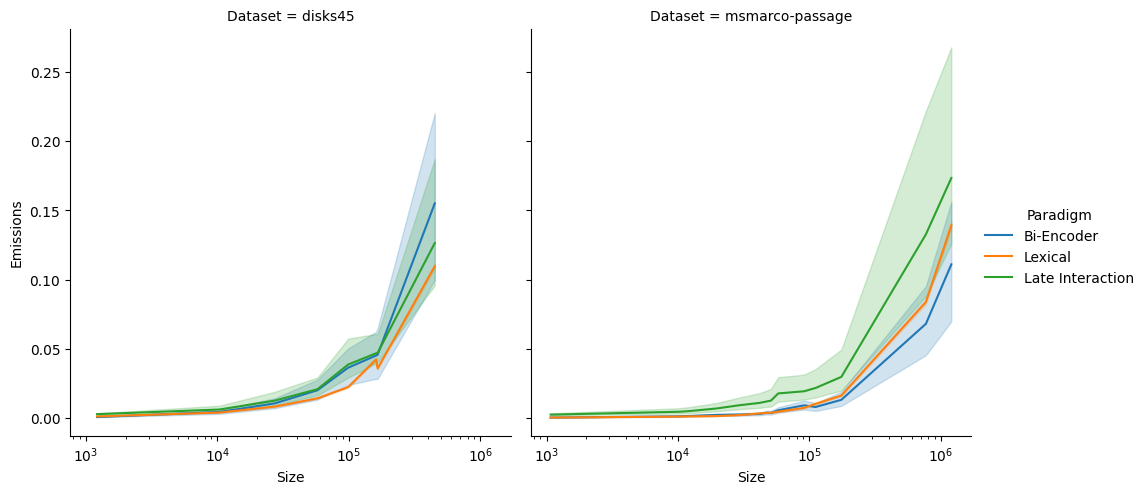

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(data=df_emissions, kind='line', x='Size', y='Emissions', col='Dataset', hue='Paradigm')
plt.xscale('log')